In [2]:
import os
os.chdir('../model_fitting/')

In [5]:
import ujson as json
import pickle, dill, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Load simulated data in model_based_var
ppc_data = json.load(open('./model_based_var/model_based_generated_var_RL_performance_sim_indiv_aff_score_precise_rt_action_manual.json', 'r'))

n_sim = len(ppc_data)
ppc_data[0].keys()
print(n_sim)

190


[173490, 173490, 173490, 173490, 173490]


/Users/YiSangHyun/anaconda3/envs/py3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


              Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     p_diff  
No. Observations:     2858        Method:                 REML    
No. Groups:           190         Scale:                  0.0280  
Min. group size:      8           Log-Likelihood:         858.4372
Max. group size:      19          Converged:              Yes     
Mean group size:      15.0                                        
------------------------------------------------------------------
                        Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------
Intercept                0.099    0.009 11.600 0.000  0.082  0.116
trial_index             -0.007    0.001 -6.659 0.000 -0.009 -0.005
Group Var                0.007    0.005                           
Group x trial_index Cov -0.001    0.000                           
trial_index Var          0.000    0.000                           



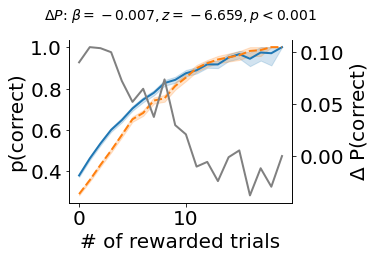

In [6]:
import seaborn as sns
import pickle, dill, glob, os
import numpy as np
import pandas as pd

def shownCond2trialByCond(shownCond, rewarded, is_new_block):
    n0 = 0
    n1 = 0
    n2 = 0
    n3 = 0
    idx = []
    for i, cond in enumerate(shownCond):
        if is_new_block[i] == 1:
            n0 = 0
            n1 = 0
            n2 = 0
            n3 = 0
        if cond == 0:
            idx.append(n0)
            if rewarded[i]:
                n0 += 1
        elif cond == 1:
            idx.append(n1)
            if rewarded[i]:
                n1 += 1            
        elif cond == 2:
            idx.append(n2)
            if rewarded[i]:
                n2 += 1   
        elif cond == 3:
            idx.append(n3)
            if rewarded[i]:
                n3 += 1
    return idx

def shown_condsTxt2conds(shown_conds):
    out = []
    for cond in shown_conds:
        if cond == "congruent high":
            out.append(0)
        elif cond == "incongruent high":
            out.append(1)
        elif cond == "congruent low":
            out.append(2)
        else:
            out.append(3)
    return out

def capitalize(txt):
    if txt == "congruent":
        return "Congruent"
    elif txt == "incongruent":
        return "Incongruent"

highChosen = []
trialIdx = []
shownCond = []
rewarded_list = []
subjIdx = []
for i in range(n_sim):
    data = ppc_data[i]
    shownCond += [capitalize(x.split()[0]) for x in data['shownCond']]
    rewarded = data['reward_list']
    trialIdx += shownCond2trialByCond(shown_condsTxt2conds(data['shownCond']), rewarded, data['is_new_block'])
    pWinOfMov = data['pWinOfMov']
    high_list = np.argmax(pWinOfMov, axis=1)
    response_list = np.array([x-1 for x in data['response_list']])
    highChosen += (high_list == response_list).tolist()
    rewarded_list += rewarded
    subjIdx += [i]*len(data['pWinOfMov'])

            
d = {'p(correct)': highChosen, 'trial index': trialIdx, 'condition': shownCond, 'rewarded': rewarded_list, 'subj':subjIdx}
print([len(x) for k, x in d.items()])
d = pd.DataFrame(data=d)

#d = d[d['rewarded']==1]
o = ["CH", "IH", "CL", "IL"]
o = ["Congruent", "Incongruent"]

d_grouped = d.groupby(['trial index', 'condition', 'subj'], as_index=False)['p(correct)'].mean()
#print(d_grouped)
d2 = pd.DataFrame(data={})

p_diff = []
t_idx = []
subj = []
f1 = d_grouped['condition'] == 'Congruent'
f2 = d_grouped['condition']=='Incongruent'
for i in range(21):
    for j in range(n_sim):
        try:
            p_c = d_grouped[f1&(d_grouped['trial index']==i)&(d_grouped['subj']==j)]['p(correct)']
            p_i = d_grouped[f2&(d_grouped['trial index']==i)&(d_grouped['subj']==j)]['p(correct)']
            p_diff.append(p_c.values[0] - p_i.values[0])
            t_idx.append(i)
            subj.append(j)
        except:
            continue

#f2 = ((d_grouped['trial index']!=20)| ((d_grouped['subj']>=80)|(d_grouped['subj']<70)))
#d2['p_diff'] = np.array(d_grouped[f1]['p(correct)']) - np.array(d_grouped[d_grouped['condition2']=='incongruent']['p(correct)'])
d2['p_diff'] = p_diff
d2['trial_index'] = t_idx
d2['subj'] = subj

import statsmodels.api as sm
import statsmodels.formula.api as smf

#model = smf.ols(formula='p_diff ~ trial_index', data=d2)
#results = model.fit()

model = smf.mixedlm('p_diff ~ trial_index', d2, groups=d2["subj"],
                   re_formula = '~ trial_index')
free = sm.regression.mixed_linear_model.MixedLMParams.from_components(
    np.ones(2), np.eye(2)
)
results = model.fit(method=["powell"], free=free)

# Extract coefficient, z-value, and p-value
trial_idx_coef = results.params['trial_index']
trial_idx_zval = results.tvalues['trial_index']
trial_idx_pval = results.pvalues['trial_index']

# Format p-value for display
if trial_idx_pval < 0.001:
    p_value_str = "p < 0.001"
else:
    p_value_str = f"p = {trial_idx_pval:.3f}"
    
print(results.summary())

d_grouped = d.groupby(['trial index', 'condition'], as_index=False)['p(correct)'].mean()
#print(d_grouped)
d2 = pd.DataFrame(data={})

f1 = d_grouped['condition'] == 'Congruent'
#f2 = ((d_grouped['trial index']!=20)| ((d_grouped['subj']>=80)|(d_grouped['subj']<70)))
l_ = min(len(d_grouped[f1]['p(correct)']), len(d_grouped[d_grouped['condition']=='Incongruent']['p(correct)']))
d2['p_diff'] = np.array(d_grouped[f1]['p(correct)'])[:l_] - np.array(d_grouped[d_grouped['condition']=='Incongruent']['p(correct)'])[:l_]
d2['trial_index'] = np.array(d_grouped[d_grouped['condition']=='Incongruent']['trial index'])[:l_]
#d2['subj'] = np.array(d_grouped[d_grouped['condition']=='Incongruent']['subj'])

from matplotlib import rcParams
import matplotlib.pylab as plt

rcParams['figure.figsize'] = 4,3
#d = d[d['trial index']<20]
ax = sns.lineplot(data=d, x="trial index", y="p(correct)", hue='condition',
                 style='condition', style_order=o, hue_order=o, linewidth = 2, legend=False)
ax2 = ax.twinx()
ax2 = sns.lineplot(data=d2, x="trial_index", y="p_diff", linewidth = 2, color='gray', ax=ax2, ci=None)

#ax.set(ylim=(0.3, 1))
#ax2.set(ylim=(-0.15, 0.15))

#b.axes.set_title("Title",fontsize=50)
ax.set_xlabel("# of rewarded trials",fontsize=20)
ax.set_ylabel("p(correct)",fontsize=20)
ax.tick_params(labelsize=20)

ax2.set_ylabel(r'$\Delta$ P(correct)',fontsize=20)
ax2.tick_params(labelsize=20)

# Set title with the formatted statistical information
plt.title(rf"$\Delta P$: $\beta = {trial_idx_coef:.3f}, z = {trial_idx_zval:.3f}, {p_value_str}$", 
          fontsize=14, pad=20)

#ax.get_legend().remove()
#ax2.get_legend().remove()

sns.despine(right=False)


#plt.legend(bbox_to_anchor=(1.60, 1), loc=2, borderaxespad=0., ncol=1)
#plt.setp(ax.get_legend().get_texts(), fontsize='15') # for legend text
#plt.setp(ax.get_legend().get_title(), fontsize='15') # for legend title

plt.savefig('/Users/YiSanghyun/Downloads/learning_curves_rewarded_trial.svg', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

/Users/YiSangHyun/anaconda3/envs/py3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


              Mixed Linear Model Regression Results
Model:                 MixedLM    Dependent Variable:    p_diff   
No. Observations:      3980       Method:                REML     
No. Groups:            190        Scale:                 0.0183   
Min. group size:       20         Log-Likelihood:        1956.7410
Max. group size:       21         Converged:             Yes      
Mean group size:       20.9                                       
------------------------------------------------------------------
                        Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------
Intercept                0.109    0.010 11.015 0.000  0.090  0.129
trial_index             -0.001    0.001 -2.258 0.024 -0.003 -0.000
Group Var                0.015    0.010                           
Group x trial_index Cov -0.000    0.000                           
trial_index Var          0.000    0.000                           



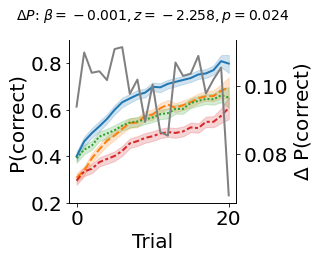

In [7]:
import seaborn as sns
from matplotlib import rcParams
import matplotlib.pylab as plt

rcParams['figure.figsize'] = 3,3

def shownCond2trialByCond(shownCond):
    n0 = 0
    n1 = 0
    n2 = 0
    n3 = 0
    idx = []
    for cond in shownCond:
        if cond == 0:
            idx.append(n0)
            n0 += 1
        elif cond == 1:
            idx.append(n1)
            n1 += 1            
        elif cond == 2:
            idx.append(n2)
            n2 += 1   
        elif cond == 3:
            idx.append(n3)
            n3 += 1
    return idx

def shown_conds2txt(shown_conds):
    out = []
    for cond in shown_conds:
        if cond == 0:
            out.append("congruent high")
        elif cond == 1:
            out.append("incongruent high")
        elif cond == 2:
            out.append("congruent low")
        else:
            out.append("incongruent low")
    return out

def draw_pval_line(pval_list, y_loc):
    pval_list1 = [pval<0.05/len(pval_list) for pval in pval_list]
    pval_list2 = [pval<0.05 for pval in pval_list]
    for i, pval in enumerate(pval_list1):
        if pval:
            #plt.plot([max(i-0.5,0), min(i+0.5, len(pval_list)-1)], [y_loc, y_loc], 'k', linewidth=1.5)
            fs=20
            plt.text(i-fs/40, y_loc, '*', fontsize=fs)
        elif pval_list2[i]:
            fs=20
            plt.text(i-fs/70, y_loc+0.035, '.', fontsize=fs)   
            
highChosen = []
trialIdx = []
shownCond = []
shownCond2 = []
subjIdx = []
for i in range(n_sim):
    data = ppc_data[i]
    shownCond += data['shownCond']
    shownCond2 += [c.split()[0] for c in data['shownCond']]
    trialIdx += data['trial_index']
    pWinOfMov = data['pWinOfMov']
    high_list = np.argmax(pWinOfMov, axis=1)
    response_list = np.array([x-1 for x in data['response_list']])
    highChosen += (high_list == response_list).tolist()
    subjIdx += [i]*len(data['trial_index'])
    

d = {'p(correct)': highChosen, 'trial index': trialIdx, 'condition': shownCond, 'condition2':shownCond2, 'subj': subjIdx}
d = pd.DataFrame(data=d)
o = ["congruent high", "incongruent high", "congruent low", "incongruent low"]

d_grouped = d.groupby(['trial index', 'condition2', 'subj'], as_index=False)['p(correct)'].mean()
#print(d_grouped)
d2 = pd.DataFrame(data={})

p_diff = []
t_idx = []
subj = []
f1 = d_grouped['condition2'] == 'congruent'
f2 = d_grouped['condition2']=='incongruent'
for i in range(21):
    for j in range(n_sim):
        try:
            p_c = d_grouped[f1&(d_grouped['trial index']==i)&(d_grouped['subj']==j)]['p(correct)']
            p_i = d_grouped[f2&(d_grouped['trial index']==i)&(d_grouped['subj']==j)]['p(correct)']
            p_diff.append(p_c.values[0] - p_i.values[0])
            t_idx.append(i)
            subj.append(j)
        except:
            continue

#f2 = ((d_grouped['trial index']!=20)| ((d_grouped['subj']>=80)|(d_grouped['subj']<70)))
#d2['p_diff'] = np.array(d_grouped[f1]['p(correct)']) - np.array(d_grouped[d_grouped['condition2']=='incongruent']['p(correct)'])
d2['p_diff'] = p_diff
d2['trial_index'] = t_idx
d2['subj'] = subj
#print(d2)

import statsmodels.api as sm
import statsmodels.formula.api as smf

#model = smf.ols(formula='p_diff ~ trial_index', data=d2)
#results = model.fit()

model = smf.mixedlm('p_diff ~ trial_index', d2, groups=d2["subj"],
                   re_formula = '~ trial_index')
free = sm.regression.mixed_linear_model.MixedLMParams.from_components(
    np.ones(2), np.eye(2)
)
results = model.fit(method=["powell"], free=free)


# Extract coefficient, z-value, and p-value
trial_idx_coef = results.params['trial_index']
trial_idx_zval = results.tvalues['trial_index']
trial_idx_pval = results.pvalues['trial_index']

# Format p-value for display
if trial_idx_pval < 0.001:
    p_value_str = "p < 0.001"
else:
    p_value_str = f"p = {trial_idx_pval:.3f}"
    
print(results.summary())

d_grouped = d.groupby(['trial index', 'condition2'], as_index=False)['p(correct)'].mean()
#print(d_grouped)
d2 = pd.DataFrame(data={})

d2 = pd.DataFrame(data={})
#print(d_grouped[d_grouped['condition2']=='congruent'])
#print(d_grouped[d_grouped['condition2']=='incongruent'])
d2['p_diff'] = np.array(d_grouped[d_grouped['condition2']=='congruent']['p(correct)']) - np.array(d_grouped[d_grouped['condition2']=='incongruent']['p(correct)'])
d2['trial_index'] = np.array(d_grouped[d_grouped['condition2']=='congruent']['trial index'])

#print(d2)



pval_list = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
ax = sns.lineplot(data=d, x="trial index", y="p(correct)", hue='condition',
                 style='condition', style_order=o, hue_order=o, linewidth = 2, legend=False)
#draw_pval_line(pval_list, 0.18)
ax2 = ax.twinx()
ax2 = sns.lineplot(data=d2, x="trial_index", y="p_diff", linewidth = 2, color='gray', ax=ax2, legend=False, ci=None)
ax.set(ylim=(0.2, 0.9))
#ax2.set(ylim=(0.02, 0.15))
#b.axes.set_title("Title",fontsize=50)
ax.set_xlabel("Trial",fontsize=20)
ax.set_ylabel("P(correct)",fontsize=20)
ax.tick_params(labelsize=20)

ax2.set_ylabel(r'$\Delta$ P(correct)',fontsize=20)
ax2.tick_params(labelsize=20)
sns.despine(right=False)

# Set title with the formatted statistical information
# Set title with upward padding
plt.title(rf"$\Delta P$: $\beta = {trial_idx_coef:.3f}, z = {trial_idx_zval:.3f}, {p_value_str}$", 
          fontsize=14, pad=20)

#ax.get_legend().remove()
#ax2.get_legend().remove()

#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1)
#plt.setp(ax.get_legend().get_texts(), fontsize='15') # for legend text
#plt.setp(ax.get_legend().get_title(), fontsize='15') # for legend title

plt.savefig('/Users/YiSanghyun/Downloads/lc.svg', dpi=300, bbox_inches='tight', transparent=True)
plt.show()





Ttest_1sampResult(statistic=9.292645658169358, pvalue=3.682233802963501e-17)


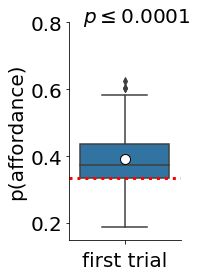

In [12]:
import seaborn as sns
from statannot import add_stat_annotation
import pickle, dill, glob, os
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

def shownCond2trialByCond(shownCond):
    n0 = 0
    n1 = 0
    n2 = 0
    n3 = 0
    idx = []
    for cond in shownCond:
        if cond == 0:
            idx.append(n0)
            n0 += 1
        elif cond == 1:
            idx.append(n1)
            n1 += 1            
        elif cond == 2:
            idx.append(n2)
            n2 += 1   
        elif cond == 3:
            idx.append(n3)
            n3 += 1
    return idx

def shown_conds2txt(shown_conds):
    out = []
    for cond in shown_conds:
        if cond == 0:
            out.append("All")
        elif cond == 1:
            out.append("All")
        elif cond == 2:
            out.append("All")
        else:
            out.append("All")
    return out
def stim2code(stim):
    if "Pinch" in stim:
        return 0
    elif "Clench" in stim:
        return 1
    elif "Poke" in stim:
        return 2
    else:
        return 3
    
def stim_array2code(stim_array):
    stim_list = stim_array
    code_list = [stim2code(stim) for stim in stim_list]
    return np.array(code_list)

def p2text(p):
    text = ""
    if p > 0.05:
        text = "n.s."
    elif p > 0.01:
        text = r'$p \leq 0.05$'
    elif p > 0.001:
        text = r'$p \leq 0.01$'
    elif p > 0.0001:
        text = r'$p \leq 0.001$'
    else:
        text = r'$p \leq 0.0001$'
    return text

highChosen = []
trialIdx = []
subjIdx = []
shownCond = []
for i in range(n_sim):
    data = ppc_data[i]
    shownCond += shown_conds2txt(data['shownCond'])
    trialIdx += data['trial_index']
    pWinOfMov = data['pWinOfMov']
    high_list = np.argmax(pWinOfMov, axis=1)
    response_list = np.array([x-1 for x in data['response_list']])
    shownStim = stim_array2code(data['shownStim'])
    highChosen += (shownStim == response_list).tolist()
    subjIdx += [i]*len(high_list)
    
d = {'p(affordance)': highChosen, 'shown condition': shownCond, 'subject index':subjIdx, 'trial index':trialIdx}
d = pd.DataFrame(data=d)
d = d[d['trial index'] == 0]
d = d.groupby(['subject index', 'shown condition'], as_index=False)['p(affordance)'].mean()

o = ["All"]

from matplotlib import rcParams
import matplotlib.pylab as plt

rcParams['figure.figsize'] = 2,4

ax = sns.boxplot(data=d, y="p(affordance)", showmeans=True, meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"})

plt.plot([-1/2, 1/2], [1/3, 1/3], linewidth=3, color='red', linestyle=':')
ax.set(ylim=(0.15, 0.8))
result = stats.ttest_1samp(d["p(affordance)"], 1/3)
print(result)
text = p2text(result[1])
#text = r'$p \leq 10^{-36}$'

#graph.plot([0, 1], [0.75, 0.75], c="black")
h = 0.0
ax.text(0.-len(text)/40., 0.80+h, text, fontsize=20)
#ax.set_title("First trial")

ax.set_xlabel("first trial",fontsize=20)
ax.set_ylabel("p(affordance)",fontsize=20)
ax.tick_params(labelsize=20)
sns.despine()

plt.savefig('/Users/YiSanghyun/Downloads/1stchoice.svg', dpi=300, bbox_inches='tight', transparent=True)
plt.show()


No handles with labels found to put in legend.


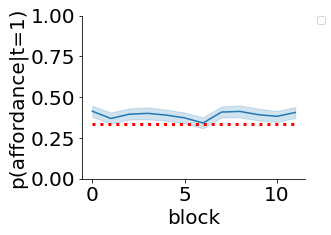

In [13]:
import seaborn as sns
from statannot import add_stat_annotation
import pickle, dill, glob, os
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

def shownCond2trialByCond(shownCond):
    n0 = 0
    n1 = 0
    n2 = 0
    n3 = 0
    idx = []
    for cond in shownCond:
        if cond == 0:
            idx.append(n0)
            n0 += 1
        elif cond == 1:
            idx.append(n1)
            n1 += 1            
        elif cond == 2:
            idx.append(n2)
            n2 += 1   
        elif cond == 3:
            idx.append(n3)
            n3 += 1
    return idx

def shown_conds2txt(shown_conds):
    out = []
    for cond in shown_conds:
        if cond == 0:
            out.append("All")
        elif cond == 1:
            out.append("All")
        elif cond == 2:
            out.append("All")
        else:
            out.append("All")
    return out
def stim2code(stim):
    if "Pinch" in stim:
        return 0
    elif "Clench" in stim:
        return 1
    elif "Poke" in stim:
        return 2
    else:
        return 3
    
def stim_array2code(stim_array):
    stim_list = stim_array
    code_list = [stim2code(stim) for stim in stim_list]
    return np.array(code_list)

def p2text(p):
    text = ""
    if p > 0.05:
        text = "n.s."
    elif p > 0.01:
        text = r'$p \leq 0.05$'
    elif p > 0.001:
        text = r'$p \leq 0.01$'
    elif p > 0.0001:
        text = r'$p \leq 0.001$'
    else:
        text = r'$p \leq 0.0001$'
    return text

highChosen = []
trialIdx = []
subjIdx = []
blockIdx = []
shownCond = []
for i in range(n_sim):
    data = ppc_data[i]
    shownCond += shown_conds2txt(data['shownCond'])
    trialIdx += data['trial_index']
    blockIdx += (np.cumsum(data['is_new_block'])-1).tolist()
    pWinOfMov = data['pWinOfMov']
    high_list = np.argmax(pWinOfMov, axis=1)
    response_list = np.array([x-1 for x in data['response_list']])
    shownStim = stim_array2code(data['shownStim'])
    highChosen += (shownStim == response_list).tolist()
    subjIdx += [i]*len(high_list)
    
d = {'p(affordance)': highChosen, 'shown condition': shownCond, 'subject index':subjIdx, 'trial index':trialIdx, 'block index':blockIdx}
d = pd.DataFrame(data=d)
d = d[d['trial index'] == 0]
#d = d.groupby(['subject index', 'shown condition', 'block index'], as_index=False)['p(affordance)'].mean()

from matplotlib import rcParams
import matplotlib.pylab as plt

rcParams['figure.figsize'] = 4,3

ax = sns.lineplot(data=d, x="block index", y="p(affordance)")
ax.set(ylim=(0, 1))
ax.set_xlabel("block",fontsize=20)
ax.set_ylabel("p(affordance|t=1)",fontsize=20)
ax.tick_params(labelsize=20)

sns.despine()

plt.plot([0, 11], [1/3, 1/3], linewidth=3, color='red', linestyle=':')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1)
plt.setp(ax.get_legend().get_texts(), fontsize='15') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='15') # for legend title
plt.savefig('/Users/YiSangHyun/Downloads/paff2.svg', dpi=300, bbox_inches='tight', transparent=True)


plt.show()
